In [2]:
!pip install --upgrade opencv-contrib-python
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-502b8abs
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-502b8abs
  Resolved https://github.com/albumentations-team/albumentations to commit 30deec1ee4f3bf8e56c43baa894de970e609852b
  Preparing metadata (setup.py) ... done


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import os
import glob
import cv2
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from albumentations import HorizontalFlip, VerticalFlip, Rotate
from tqdm import tqdm
import torch.nn.functional as F
import matplotlib.image as mpimg
import albumentations as A

height,width = (256, 256)


torch.cuda.is_available()

True

In [4]:
class LoadData(Dataset):
    def __init__(self, images_path, masks_path):
        super().__init__()

        self.images_path = images_path
        self.masks_path = masks_path
        self.len = len(images_path)
        self.transform = A.Compose([
            A.Resize(height,width),
            A.HorizontalFlip(),
            A.RandomBrightnessContrast(p=0.5),
            A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        ])
        

    def __getitem__(self, idx):
        img = Image.open(self.images_path[idx])
        mask = Image.open(self.masks_path[idx]).convert('L')
        
        img,mask=np.array(img),np.array(mask)
        transformed = self.transform(image=img, mask=mask)
        img = transformed['image']
        mask = transformed['mask']

        img = np.transpose(img, (2, 0, 1))
        img = img/255.0
        img = torch.tensor(img)

        mask = np.expand_dims(mask, axis=0)
        mask = mask/255.0
        mask = torch.tensor(mask)

        return img, mask
    
    def __len__(self):
        return self.len

In [5]:
X = sorted(glob.glob('../input/satellite-images-of-water-bodies/Water Bodies Dataset/Images/*'))
y = sorted(glob.glob('../input/satellite-images-of-water-bodies/Water Bodies Dataset/Masks/*'))

In [6]:
len(y)

2841

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

In [8]:
train_dataset = LoadData(X_train, y_train)
valid_dataset = LoadData(X_val, y_val)

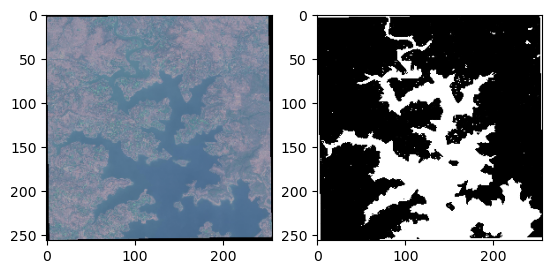

In [9]:
img, mask = train_dataset[18]

f, axarr = plt.subplots(1,2) 
axarr[1].imshow(np.squeeze(mask.numpy()), cmap='gray')
axarr[0].imshow(np.transpose(img.numpy(), (1,2,0)))

In [10]:
DEVICE='cuda'

EPOCHS=45
BATCH_SIZE=32
LR=0.001

ratio=0.5 #Various ratios could perform better for visualization
sample_num=18

ENCODER='resnet50'
WEIGHTS='imagenet'

In [11]:
train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=2,
)

valid_loader = DataLoader(
        dataset=valid_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=2,
)

In [12]:
!pip install segmentation-models-pytorch
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [38]:
# import torch
# import torch.nn as nn
# import pickle
# import torch.nn.functional as F


# class DoubleConv(nn.Module):
#     """(convolution => [BN] => ReLU) * 2"""

#     def __init__(self, in_channels, out_channels, mid_channels=None):
#         super().__init__()
#         if not mid_channels:
#             mid_channels = out_channels
#         self.double_conv = nn.Sequential(
#             nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
#             nn.BatchNorm2d(mid_channels),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
#             nn.BatchNorm2d(out_channels),
#             nn.ReLU(inplace=True)
#         )

#     def forward(self, x):
#         return self.double_conv(x)


# class Down(nn.Module):
#     """Downscaling with maxpool then double conv"""

#     def __init__(self, in_channels, out_channels):
#         super().__init__()
#         self.maxpool_conv = nn.Sequential(
#             nn.MaxPool2d(2),
#             DoubleConv(in_channels, out_channels)
#         )

#     def forward(self, x):
#         return self.maxpool_conv(x)


# class Up(nn.Module):
#     """Upscaling then double conv"""

#     def __init__(self, in_channels, out_channels, bilinear=True):
#         super().__init__()

#         # if bilinear, use the normal convolutions to reduce the number of channels
#         if bilinear:
#             self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
#             self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
#         else:
#             self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
#             self.conv = DoubleConv(in_channels, out_channels)

#     def forward(self, x1, x2):
#         x1 = self.up(x1)
#         # input is CHW
#         diffY = x2.size()[2] - x1.size()[2]
#         diffX = x2.size()[3] - x1.size()[3]

#         x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
#                         diffY // 2, diffY - diffY // 2])
#         # if you have padding issues, see
#         # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
#         # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
#         x = torch.cat([x2, x1], dim=1)
#         return self.conv(x)


# class OutConv(nn.Module):
#     def __init__(self, in_channels, out_channels):
#         super(OutConv, self).__init__()
#         self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

#     def forward(self, x):
#         return self.conv(x)

# class UNet(nn.Module):
#     def __init__(self, n_channels, n_classes, bilinear=False):
#         super(UNet, self).__init__()
#         self.n_channels = n_channels
#         self.n_classes = n_classes
#         self.bilinear = bilinear

#         self.inc = (DoubleConv(n_channels, 64))
#         self.down1 = (Down(64, 128))
#         self.down2 = (Down(128, 256))
#         self.down3 = (Down(256, 512))
#         factor = 2 if bilinear else 1
#         self.down4 = (Down(512, 1024 // factor))
#         self.up1 = (Up(1024, 512 // factor, bilinear))
#         self.up2 = (Up(512, 256 // factor, bilinear))
#         self.up3 = (Up(256, 128 // factor, bilinear))
#         self.up4 = (Up(128, 64, bilinear))
#         self.outc = (OutConv(64, n_classes))

#     def forward(self, x):
#         x1 = self.inc(x)
#         x2 = self.down1(x1)
#         x3 = self.down2(x2)
#         x4 = self.down3(x3)
#         x5 = self.down4(x4)
#         x = self.up1(x5, x4)
#         x = self.up2(x, x3)
#         x = self.up3(x, x2)
#         x = self.up4(x, x1)
#         logits = self.outc(x)
#         return logits

#     def use_checkpointing(self):
#         self.inc = torch.utils.checkpoint(self.inc)
#         self.down1 = torch.utils.checkpoint(self.down1)
#         self.down2 = torch.utils.checkpoint(self.down2)
#         self.down3 = torch.utils.checkpoint(self.down3)
#         self.down4 = torch.utils.checkpoint(self.down4)
#         self.up1 = torch.utils.checkpoint(self.up1)
#         self.up2 = torch.utils.checkpoint(self.up2)
#         self.up3 = torch.utils.checkpoint(self.up3)
#         self.up4 = torch.utils.checkpoint(self.up4)
#         self.outc = torch.utils.checkpoint(self.outc)


#     def save(self, filepath="./model.pkl"):
#         """
#         Saves the Network model in the given filepath.
#         Parameters
#         ----------
#         filepath: filepath of the model to be saved
#         Returns
#         -------
#         None
#         """
#         with open(filepath, 'wb') as f:
#             pickle.dump(self, f)

#     def load(self, filepath="./model.pkl"):
#         """
#         Loads a pre-trained Network model from the given filepath.
#         Parameters
#         ----------
#         filepath: filepath of the model to be loaded
#         Returns
#         -------
#         model: Loaded Network model
#         """
#         with open(filepath, 'rb') as f:
#             return pickle.load(f)

In [39]:
# #GPT U-net
# import torch
# import torch.nn as nn
# import torch.nn.functional as F

# class UNet(nn.Module):
#     def __init__(self, in_channels, n_classes):
#         super(UNet, self).__init__()

#         def conv_block(in_dim, out_dim):
#             return nn.Sequential(
#                 nn.Conv2d(in_dim, out_dim, kernel_size=3, padding=1),
#                 nn.ReLU(inplace=True),
#                 nn.Conv2d(out_dim, out_dim, kernel_size=3, padding=1),
#                 nn.ReLU(inplace=True)
#             )

#         def up_conv(in_dim, out_dim):
#             return nn.ConvTranspose2d(in_dim, out_dim, kernel_size=2, stride=2)

#         # Contracting Path (downsampling)
#         self.conv1 = conv_block(in_channels, 64)
#         self.conv2 = conv_block(64, 128)
#         self.conv3 = conv_block(128, 256)
#         self.conv4 = conv_block(256, 512)

#         self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

#         # Expanding Path (upsampling)
#         self.up_conv3 = up_conv(512, 256)
#         self.up_conv2 = up_conv(256, 128)
#         self.up_conv1 = up_conv(128, 64)

#         self.conv3m = conv_block(512, 256)
#         self.conv2m = conv_block(256, 128)
#         self.conv1m = conv_block(128, 64)

#         # Output layer
#         self.conv0m = nn.Conv2d(64, n_classes, kernel_size=1)

#     def forward(self, x):
#         # Downsampling
#         conv1 = self.conv1(x)
#         x = self.pool(conv1)
#         conv2 = self.conv2(x)
#         x = self.pool(conv2)
#         conv3 = self.conv3(x)
#         x = self.pool(conv3)
#         conv4 = self.conv4(x)

#         # Upsampling
#         x = self.up_conv3(conv4)
#         x = torch.cat([x, conv3], dim=1)
#         x = self.conv3m(x)
#         x = self.up_conv2(x)
#         x = torch.cat([x, conv2], dim=1)
#         x = self.conv2m(x)
#         x = self.up_conv1(x)
#         x = torch.cat([x, conv1], dim=1)
#         x = self.conv1m(x)
#         x = self.conv0m(x)

#         return x

In [13]:
!pip install segmentation-models-pytorch
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [14]:
class SegmentationModel(nn.Module):
    def __init__(self):
        super(SegmentationModel,self).__init__()

        self.arc=smp.Unet(
            encoder_name=ENCODER,
            encoder_weights=WEIGHTS,
            in_channels=3,
            classes=1,
            activation=None
        )
    
#         self.arc = UNet(3, 1)
    
    def forward(self,images,masks=None):
        logits=self.arc(images)

        if masks!=None:
            loss1=DiceLoss(mode='binary')(logits,masks)
            loss2=nn.BCEWithLogitsLoss()(logits,masks)
            return logits,loss1,loss2
        return logits

In [15]:
model=SegmentationModel()
model.to(DEVICE)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 256MB/s]


SegmentationModel(
  (arc): Unet(
    (encoder): ResNetEncoder(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReL

In [16]:
def iou(pred_mask, true_mask, n_classes=2):
    ious = []
#     pred= torch.argmax(pred, dim =1)
    pred = pred_mask.view(-1)
    target = true_mask.view(-1)

    # Ignore IoU for undefined class ("9")
    for cls in range(n_classes-1):  # last class is ignored

        pred_inds = pred == cls
        target_inds = target == cls
        intersection = torch.sum(pred_inds & target_inds)
        union = torch.sum(pred_inds | target_inds)
        if float(union) == 0:
            ious.append(float('nan'))  # If there is no ground truth, do not include in evaluation
        else:
            ious.append(float(intersection / union))


    return torch.mean(torch.Tensor(ious)).item()

In [17]:
def train_fn(data_loader,model,optimizer):
    model.train()
    total_diceloss=0.0
    total_bceloss=0.0
    total_loss = 0.0
    total_iou = 0.0
    count =0
    for images ,masks in tqdm(data_loader):
        images=images.to(DEVICE, dtype=torch.float32)
        masks=masks.to(DEVICE, dtype=torch.float32)
        
        optimizer.zero_grad()

        logits,diceloss,bceloss=model(images,masks)
        
        
        diceloss.backward(retain_graph=True)
        bceloss.backward()
        
        optimizer.step()
        total_diceloss+=diceloss.item()
        total_bceloss+=bceloss.item()
        
        pred_mask=torch.sigmoid(logits)
        pred_mask=(pred_mask > ratio)*1.0
        total_iou += iou(pred_mask, masks)
        count+=1
    print("IoU train,", total_iou/count)
    
#         intersection = torch.logical_and(logits, masks).sum()
#         union = torch.logical_or(logits, masks).sum()
#         iou = intersection.float() / union.float()
#         print("iou train:",iou)
        

    return total_diceloss/len(data_loader),total_bceloss/len(data_loader)

In [18]:
def eval_fn(data_loader,model):
    model.eval()
    total_diceloss=0.0
    total_bceloss=0.0
    total_iou=0
    count = 0
    with torch.no_grad():
        for images ,masks in tqdm(data_loader):
            images=images.to(DEVICE, dtype=torch.float32)
            masks=masks.to(DEVICE, dtype=torch.float32)

            logits,diceloss,bceloss=model(images,masks)
            total_diceloss+=diceloss.item()
            total_bceloss+=bceloss.item()
            
            pred_mask=torch.sigmoid(logits)
            pred_mask=(pred_mask > ratio)*1.0
            total_iou += iou(pred_mask, masks)
            count+=1
            
        #Visualization
        for i in range(1):
            image,mask=next(iter(valid_loader))
            image=image[sample_num]
            mask=mask[sample_num]
            logits_mask=model(image.to('cuda', dtype=torch.float32).unsqueeze(0))
            pred_mask=torch.sigmoid(logits_mask)
            pred_mask=(pred_mask > ratio)*1.0
            f, axarr = plt.subplots(1,3) 
            axarr[1].imshow(np.squeeze(mask.numpy()), cmap='gray')
            axarr[0].imshow(np.transpose(image.numpy(), (1,2,0)))
            axarr[2].imshow(np.transpose(pred_mask.detach().cpu().squeeze(0), (1,2,0)))
            plt.show()
    
    print("IoU val,", total_iou/count)
    return total_diceloss/len(data_loader),total_bceloss/len(data_loader)

In [19]:
optimizer=torch.optim.SGD(model.parameters(), lr=LR, momentum=0.9)
print("device", DEVICE)
#torch.optim.Adam(model.parameters(),lr=LR)

device cuda


100%|██████████| 80/80 [00:56<00:00,  1.41it/s]


IoU train, 0.5571339588612318


100%|██████████| 9/9 [00:05<00:00,  1.57it/s]


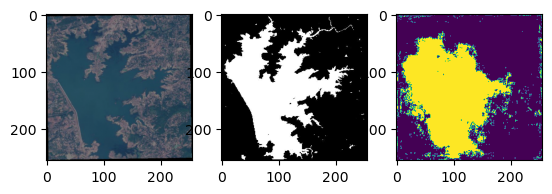

IoU val, 0.6971628533469306
Epochs:1
Train_loss --> Dice: 0.535209346562624 BCE: 0.5907945241779089 
Valid_loss --> Dice: 0.4222656422191196 BCE: 0.4415336185031467
Model Saved


100%|██████████| 80/80 [00:49<00:00,  1.62it/s]


IoU train, 0.7244080595672131


100%|██████████| 9/9 [00:04<00:00,  1.94it/s]


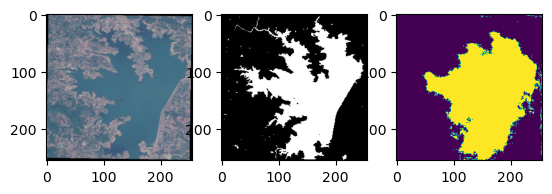

IoU val, 0.7643991973665025
Epochs:2
Train_loss --> Dice: 0.3636944077908993 BCE: 0.4043652221560478 
Valid_loss --> Dice: 0.3155059615770976 BCE: 0.3422742750909593
Model Saved


100%|██████████| 80/80 [00:49<00:00,  1.62it/s]


IoU train, 0.7558385595679283


100%|██████████| 9/9 [00:04<00:00,  1.89it/s]


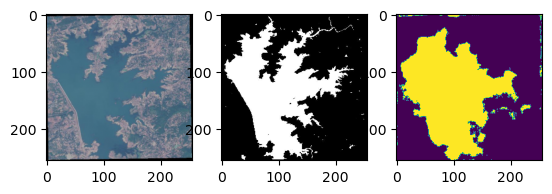

IoU val, 0.7782705426216125
Epochs:3
Train_loss --> Dice: 0.2959231048822403 BCE: 0.3552507471293211 
Valid_loss --> Dice: 0.28434384531444973 BCE: 0.32214545210202533
Model Saved


100%|██████████| 80/80 [00:49<00:00,  1.63it/s]


IoU train, 0.7705040886998177


100%|██████████| 9/9 [00:04<00:00,  1.97it/s]


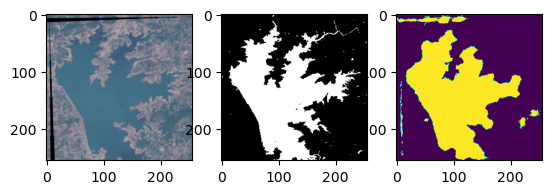

IoU val, 0.782018264134725
Epochs:4
Train_loss --> Dice: 0.2652779646217823 BCE: 0.33056203592568634 
Valid_loss --> Dice: 0.2682887580659654 BCE: 0.3083392282327016
Model Saved


100%|██████████| 80/80 [00:49<00:00,  1.62it/s]


IoU train, 0.7779114119708538


100%|██████████| 9/9 [00:05<00:00,  1.79it/s]


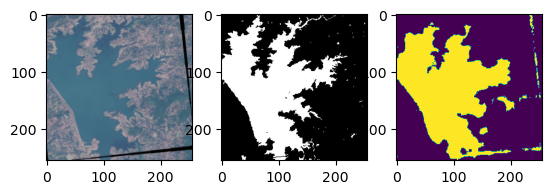

IoU val, 0.7911534640524123
Epochs:5
Train_loss --> Dice: 0.24940340593457222 BCE: 0.3142589073628187 
Valid_loss --> Dice: 0.25125031338797676 BCE: 0.299300202065044
Model Saved


100%|██████████| 80/80 [00:49<00:00,  1.63it/s]


IoU train, 0.786958322674036


100%|██████████| 9/9 [00:04<00:00,  1.95it/s]


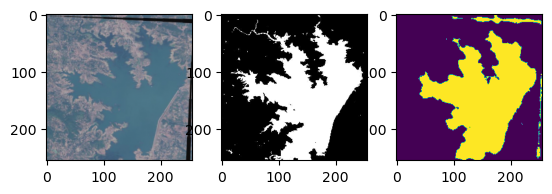

IoU val, 0.7981966336568197
Epochs:6
Train_loss --> Dice: 0.2326709099113941 BCE: 0.2965759186074138 
Valid_loss --> Dice: 0.23816251092486912 BCE: 0.2867375711599986
Model Saved


100%|██████████| 80/80 [00:48<00:00,  1.64it/s]


IoU train, 0.7916933909058571


100%|██████████| 9/9 [00:04<00:00,  1.98it/s]


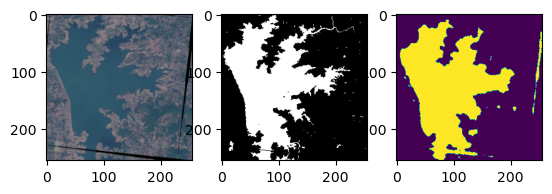

IoU val, 0.7943451139662001
Epochs:7
Train_loss --> Dice: 0.2224833771586418 BCE: 0.28841154016554355 
Valid_loss --> Dice: 0.2392242948214213 BCE: 0.29049837589263916


100%|██████████| 80/80 [00:49<00:00,  1.62it/s]


IoU train, 0.7977806232869625


100%|██████████| 9/9 [00:04<00:00,  1.91it/s]


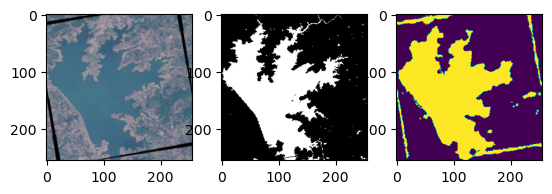

IoU val, 0.8047450118594699
Epochs:8
Train_loss --> Dice: 0.2129790097475052 BCE: 0.2772626021876931 
Valid_loss --> Dice: 0.22175930605994332 BCE: 0.2753737320502599
Model Saved


100%|██████████| 80/80 [00:49<00:00,  1.62it/s]


IoU train, 0.799514501541853


100%|██████████| 9/9 [00:04<00:00,  1.86it/s]


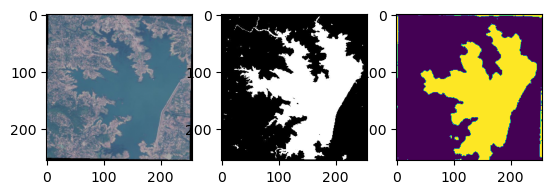

IoU val, 0.8026879098680284
Epochs:9
Train_loss --> Dice: 0.20914407894015313 BCE: 0.27318637147545816 
Valid_loss --> Dice: 0.22307308514912924 BCE: 0.2735479027032852
Model Saved


100%|██████████| 80/80 [00:48<00:00,  1.64it/s]


IoU train, 0.803907997906208


100%|██████████| 9/9 [00:04<00:00,  1.90it/s]


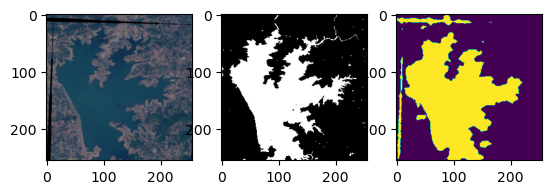

IoU val, 0.8031878802511427
Epochs:10
Train_loss --> Dice: 0.20099740400910376 BCE: 0.26665304135531187 
Valid_loss --> Dice: 0.21899857785966662 BCE: 0.27703021797868943
Model Saved


100%|██████████| 80/80 [00:49<00:00,  1.61it/s]


IoU train, 0.8048580139875412


100%|██████████| 9/9 [00:04<00:00,  1.88it/s]


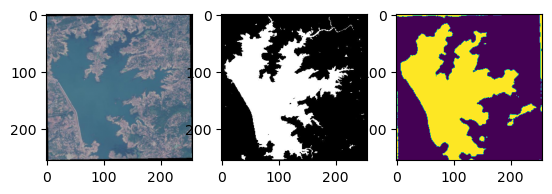

IoU val, 0.805773138999939
Epochs:11
Train_loss --> Dice: 0.1998903773725033 BCE: 0.2622234720736742 
Valid_loss --> Dice: 0.2155742049217224 BCE: 0.26266027324729496
Model Saved


100%|██████████| 80/80 [00:49<00:00,  1.63it/s]


IoU train, 0.8108279958367348


100%|██████████| 9/9 [00:04<00:00,  1.89it/s]


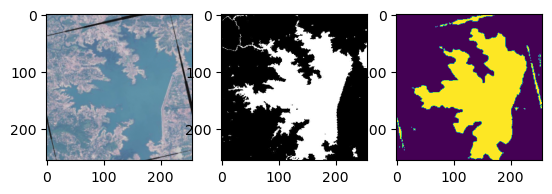

IoU val, 0.8075092633565267
Epochs:12
Train_loss --> Dice: 0.1907656155526638 BCE: 0.24871147014200687 
Valid_loss --> Dice: 0.2080019579993354 BCE: 0.2655099464787377
Model Saved


100%|██████████| 80/80 [00:49<00:00,  1.60it/s]


IoU train, 0.810750239342451


100%|██████████| 9/9 [00:04<00:00,  1.92it/s]


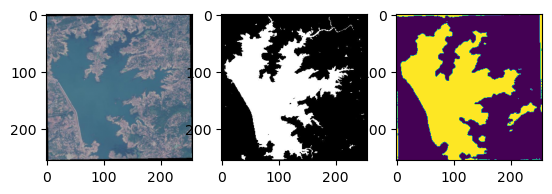

IoU val, 0.8072399563259549
Epochs:13
Train_loss --> Dice: 0.1879938893020153 BCE: 0.2497105307877064 
Valid_loss --> Dice: 0.20905683437983194 BCE: 0.2625458108054267
Model Saved


100%|██████████| 80/80 [00:49<00:00,  1.62it/s]


IoU train, 0.8145339548587799


100%|██████████| 9/9 [00:04<00:00,  1.94it/s]


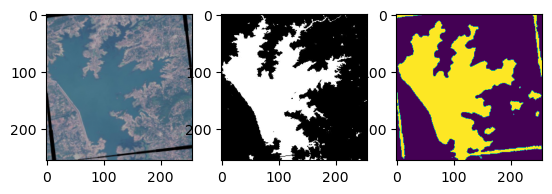

IoU val, 0.8103475107087029
Epochs:14
Train_loss --> Dice: 0.1832215204834938 BCE: 0.2414985066279769 
Valid_loss --> Dice: 0.2016305989689297 BCE: 0.2655466811524497
Model Saved


100%|██████████| 80/80 [00:49<00:00,  1.63it/s]


IoU train, 0.8171834222972393


100%|██████████| 9/9 [00:05<00:00,  1.63it/s]


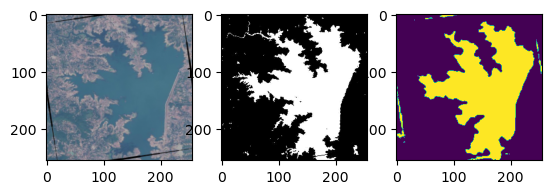

IoU val, 0.8112876349025302
Epochs:15
Train_loss --> Dice: 0.17861248925328255 BCE: 0.2376974681392312 
Valid_loss --> Dice: 0.19732771979437935 BCE: 0.26350969407293534
Model Saved


100%|██████████| 80/80 [00:49<00:00,  1.61it/s]


IoU train, 0.81881293207407


100%|██████████| 9/9 [00:04<00:00,  1.90it/s]


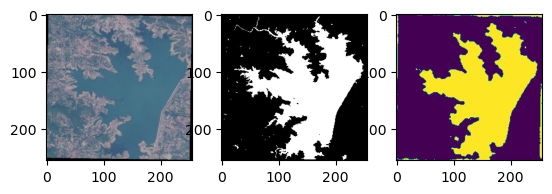

IoU val, 0.8153121802541945
Epochs:16
Train_loss --> Dice: 0.17538026124238967 BCE: 0.2362261788919568 
Valid_loss --> Dice: 0.19127802716361153 BCE: 0.25699517793125576
Model Saved


100%|██████████| 80/80 [00:49<00:00,  1.61it/s]


IoU train, 0.8198056928813457


100%|██████████| 9/9 [00:04<00:00,  1.95it/s]


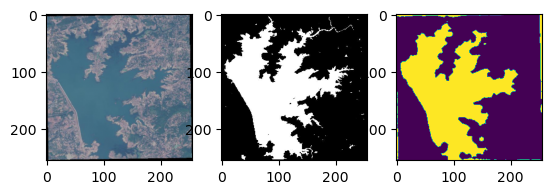

IoU val, 0.8113027546140883
Epochs:17
Train_loss --> Dice: 0.17323244512081146 BCE: 0.2302307950332761 
Valid_loss --> Dice: 0.1976537373330858 BCE: 0.26737286316023934


100%|██████████| 80/80 [00:49<00:00,  1.63it/s]


IoU train, 0.822009702026844


100%|██████████| 9/9 [00:04<00:00,  1.99it/s]


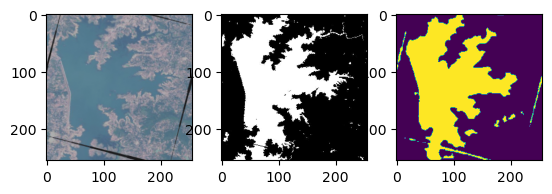

IoU val, 0.8117004632949829
Epochs:18
Train_loss --> Dice: 0.1712602950632572 BCE: 0.22684643138200045 
Valid_loss --> Dice: 0.19834566116333008 BCE: 0.26387766500314075


100%|██████████| 80/80 [00:49<00:00,  1.62it/s]


IoU train, 0.8256127268075943


100%|██████████| 9/9 [00:04<00:00,  1.91it/s]


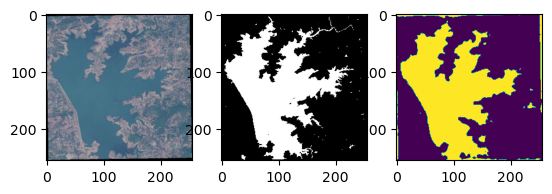

IoU val, 0.8122937480608622
Epochs:19
Train_loss --> Dice: 0.16417109817266465 BCE: 0.21826655175536872 
Valid_loss --> Dice: 0.19282477431827122 BCE: 0.25770901805824703


100%|██████████| 80/80 [00:49<00:00,  1.62it/s]


IoU train, 0.8249942772090435


100%|██████████| 9/9 [00:04<00:00,  1.83it/s]


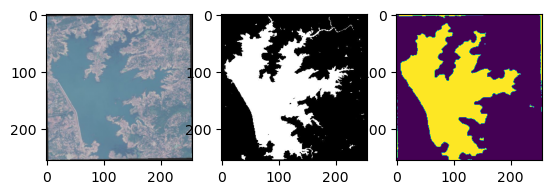

IoU val, 0.813848594824473
Epochs:20
Train_loss --> Dice: 0.16560237631201744 BCE: 0.21915616784244776 
Valid_loss --> Dice: 0.1943771375550164 BCE: 0.26387665172417957


100%|██████████| 80/80 [00:49<00:00,  1.61it/s]


IoU train, 0.8286320626735687


100%|██████████| 9/9 [00:04<00:00,  1.93it/s]


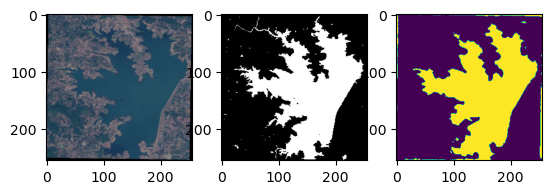

IoU val, 0.8168487548828125
Epochs:21
Train_loss --> Dice: 0.16020321995019912 BCE: 0.21215839590877295 
Valid_loss --> Dice: 0.18647806511984932 BCE: 0.25089829829004073
Model Saved


100%|██████████| 80/80 [00:49<00:00,  1.62it/s]


IoU train, 0.8301574110984802


100%|██████████| 9/9 [00:04<00:00,  1.92it/s]


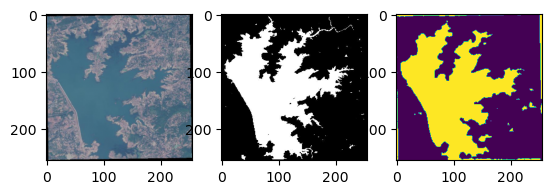

IoU val, 0.8153887523545159
Epochs:22
Train_loss --> Dice: 0.15627321526408194 BCE: 0.2105761518701911 
Valid_loss --> Dice: 0.18936791022618613 BCE: 0.2530574318435457


100%|██████████| 80/80 [00:49<00:00,  1.62it/s]


IoU train, 0.8299430355429649


100%|██████████| 9/9 [00:04<00:00,  1.93it/s]


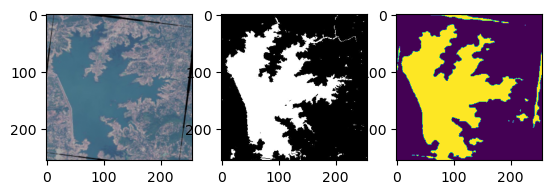

IoU val, 0.8199741840362549
Epochs:23
Train_loss --> Dice: 0.15594149604439736 BCE: 0.20826881881803275 
Valid_loss --> Dice: 0.18369745545917088 BCE: 0.2436593638526069
Model Saved


100%|██████████| 80/80 [00:48<00:00,  1.64it/s]


IoU train, 0.8311451196670532


100%|██████████| 9/9 [00:04<00:00,  1.96it/s]


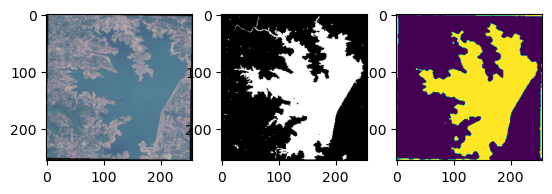

IoU val, 0.8156244092517428
Epochs:24
Train_loss --> Dice: 0.1540857419371605 BCE: 0.20712426584213972 
Valid_loss --> Dice: 0.18833976984024048 BCE: 0.25621647967232597


100%|██████████| 80/80 [00:49<00:00,  1.63it/s]


IoU train, 0.8330054394900799


100%|██████████| 9/9 [00:04<00:00,  1.90it/s]


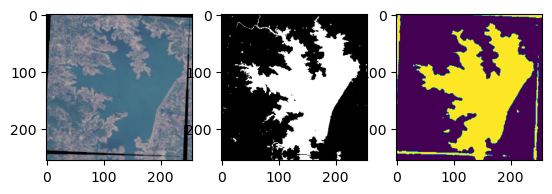

IoU val, 0.8213951587677002
Epochs:25
Train_loss --> Dice: 0.15277389958500862 BCE: 0.20316597074270248 
Valid_loss --> Dice: 0.1805264817343818 BCE: 0.23997555507553947
Model Saved


100%|██████████| 80/80 [00:49<00:00,  1.63it/s]


IoU train, 0.8353416085243225


100%|██████████| 9/9 [00:04<00:00,  1.91it/s]


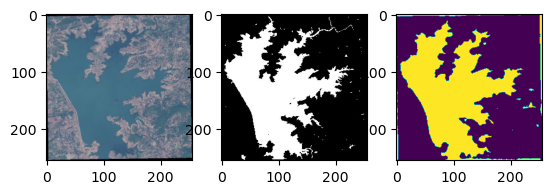

IoU val, 0.8220487700568305
Epochs:26
Train_loss --> Dice: 0.1486511245369911 BCE: 0.19902805536985396 
Valid_loss --> Dice: 0.17793806393941244 BCE: 0.23951173490948147
Model Saved


100%|██████████| 80/80 [00:49<00:00,  1.63it/s]


IoU train, 0.8351826056838035


100%|██████████| 9/9 [00:04<00:00,  1.88it/s]


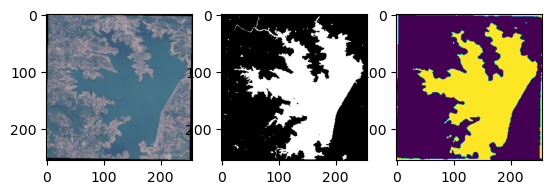

IoU val, 0.8221002486017015
Epochs:27
Train_loss --> Dice: 0.14732806459069253 BCE: 0.19866656232625246 
Valid_loss --> Dice: 0.17784855763117471 BCE: 0.24733574191729227
Model Saved


100%|██████████| 80/80 [00:49<00:00,  1.61it/s]


IoU train, 0.8371144495904446


100%|██████████| 9/9 [00:04<00:00,  1.96it/s]


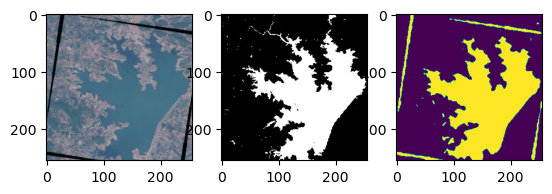

IoU val, 0.819011906782786
Epochs:28
Train_loss --> Dice: 0.14554161131381987 BCE: 0.19286523424088955 
Valid_loss --> Dice: 0.1798661020067003 BCE: 0.2515506098667781


100%|██████████| 80/80 [00:49<00:00,  1.61it/s]


IoU train, 0.8364658161997796


100%|██████████| 9/9 [00:04<00:00,  1.87it/s]


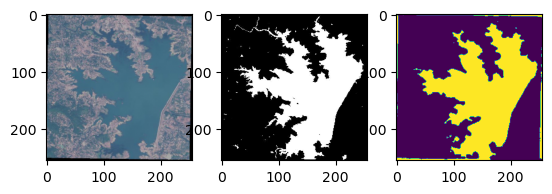

IoU val, 0.8194863266415067
Epochs:29
Train_loss --> Dice: 0.14577711522579193 BCE: 0.19505740087479354 
Valid_loss --> Dice: 0.17835676007800633 BCE: 0.25050926870769924


100%|██████████| 80/80 [00:50<00:00,  1.59it/s]


IoU train, 0.8397201605141162


100%|██████████| 9/9 [00:04<00:00,  1.95it/s]


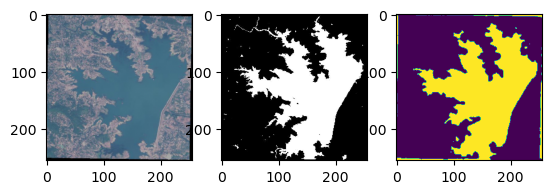

IoU val, 0.8239815301365323
Epochs:30
Train_loss --> Dice: 0.14054013192653655 BCE: 0.18897560741752387 
Valid_loss --> Dice: 0.17222703165478176 BCE: 0.23907024496131474
Model Saved


100%|██████████| 80/80 [00:48<00:00,  1.63it/s]


IoU train, 0.8407636404037475


100%|██████████| 9/9 [00:04<00:00,  1.92it/s]


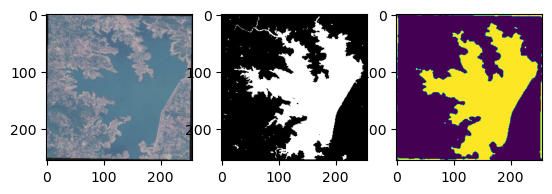

IoU val, 0.8227260907491049
Epochs:31
Train_loss --> Dice: 0.13734692260622977 BCE: 0.18626915914937853 
Valid_loss --> Dice: 0.17133980327182347 BCE: 0.2500057468811671
Model Saved


100%|██████████| 80/80 [00:49<00:00,  1.62it/s]


IoU train, 0.8410386241972446


100%|██████████| 9/9 [00:04<00:00,  1.92it/s]


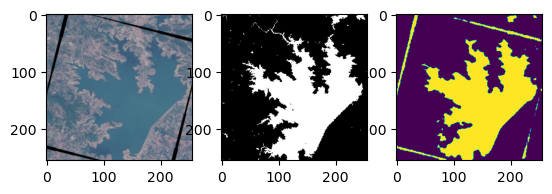

IoU val, 0.8263471590148078
Epochs:32
Train_loss --> Dice: 0.13850629478693008 BCE: 0.18641253244131803 
Valid_loss --> Dice: 0.1688271098666721 BCE: 0.24201464984152052
Model Saved


100%|██████████| 80/80 [00:49<00:00,  1.63it/s]


IoU train, 0.8411152698099613


100%|██████████| 9/9 [00:04<00:00,  1.99it/s]


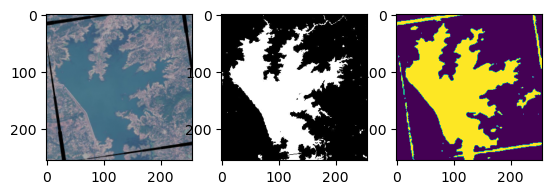

IoU val, 0.82232842180464
Epochs:33
Train_loss --> Dice: 0.13821495398879052 BCE: 0.1861365908756852 
Valid_loss --> Dice: 0.17274581723743015 BCE: 0.2448457164896859


100%|██████████| 80/80 [00:48<00:00,  1.64it/s]


IoU train, 0.8439390726387501


100%|██████████| 9/9 [00:04<00:00,  1.81it/s]


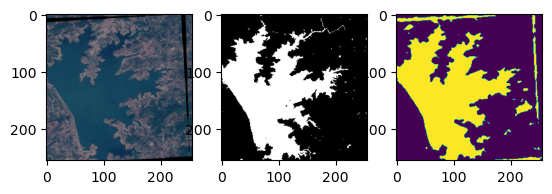

IoU val, 0.8276878131760491
Epochs:34
Train_loss --> Dice: 0.13444687947630882 BCE: 0.18084253445267678 
Valid_loss --> Dice: 0.1664272877905104 BCE: 0.23501374158594343
Model Saved


100%|██████████| 80/80 [00:48<00:00,  1.63it/s]


IoU train, 0.8423076309263706


100%|██████████| 9/9 [00:04<00:00,  2.03it/s]


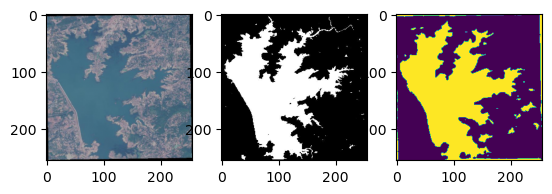

IoU val, 0.8203350239329867
Epochs:35
Train_loss --> Dice: 0.13654217198491098 BCE: 0.18367077223956585 
Valid_loss --> Dice: 0.17652406957414415 BCE: 0.2482870982752906


100%|██████████| 80/80 [00:49<00:00,  1.62it/s]


IoU train, 0.8446596980094909


100%|██████████| 9/9 [00:04<00:00,  2.06it/s]


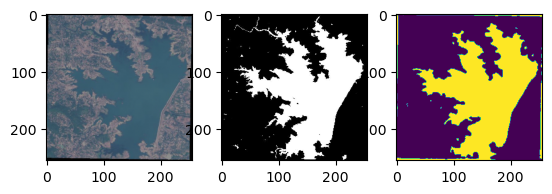

IoU val, 0.8245670994122823
Epochs:36
Train_loss --> Dice: 0.1318752348423004 BCE: 0.17908087661489844 
Valid_loss --> Dice: 0.17005507151285806 BCE: 0.24018789331118265


100%|██████████| 80/80 [00:49<00:00,  1.62it/s]


IoU train, 0.8467412732541562


100%|██████████| 9/9 [00:04<00:00,  2.03it/s]


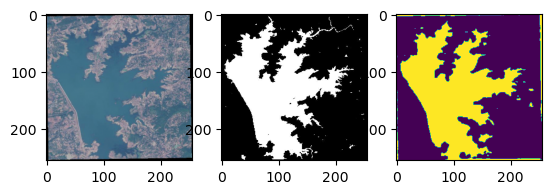

IoU val, 0.8255149258507622
Epochs:37
Train_loss --> Dice: 0.12996141314506532 BCE: 0.17555891079828143 
Valid_loss --> Dice: 0.16865685251024035 BCE: 0.24261126087771523


100%|██████████| 80/80 [00:48<00:00,  1.65it/s]


IoU train, 0.8449797011911869


100%|██████████| 9/9 [00:04<00:00,  2.02it/s]


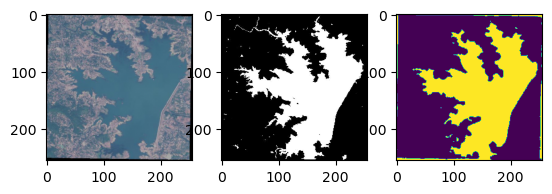

IoU val, 0.8223444620768229
Epochs:38
Train_loss --> Dice: 0.1316325068473816 BCE: 0.17830296074971558 
Valid_loss --> Dice: 0.17188848389519584 BCE: 0.24689177340931362


100%|██████████| 80/80 [00:48<00:00,  1.63it/s]


IoU train, 0.847308649122715


100%|██████████| 9/9 [00:04<00:00,  1.81it/s]


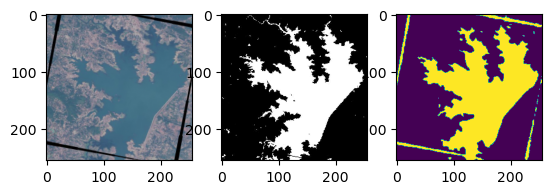

IoU val, 0.8248137633005778
Epochs:39
Train_loss --> Dice: 0.12829838171601296 BCE: 0.17332199560478329 
Valid_loss --> Dice: 0.16964188549253675 BCE: 0.2426836093266805


100%|██████████| 80/80 [00:48<00:00,  1.64it/s]


IoU train, 0.8473875552415848


100%|██████████| 9/9 [00:04<00:00,  2.00it/s]


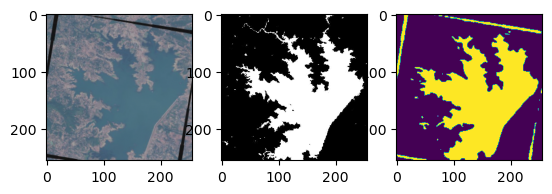

IoU val, 0.8204696045981513
Epochs:40
Train_loss --> Dice: 0.1280563496053219 BCE: 0.1748201113194227 
Valid_loss --> Dice: 0.17085101869371203 BCE: 0.2461718718210856


100%|██████████| 80/80 [00:49<00:00,  1.60it/s]


IoU train, 0.8485025838017464


100%|██████████| 9/9 [00:04<00:00,  2.01it/s]


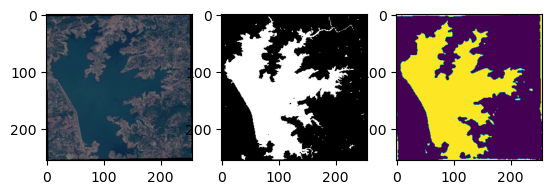

IoU val, 0.8298865026897855
Epochs:41
Train_loss --> Dice: 0.12536221519112586 BCE: 0.17036764286458492 
Valid_loss --> Dice: 0.16218246353997123 BCE: 0.2350467493136724
Model Saved


100%|██████████| 80/80 [00:48<00:00,  1.63it/s]


IoU train, 0.8501509070396424


100%|██████████| 9/9 [00:04<00:00,  2.04it/s]


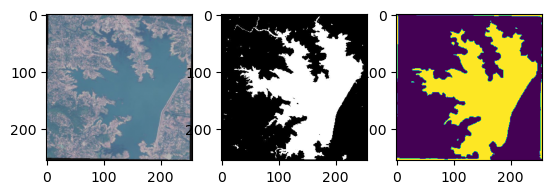

IoU val, 0.8287687632772658
Epochs:42
Train_loss --> Dice: 0.12343781515955925 BCE: 0.16804968966171147 
Valid_loss --> Dice: 0.16216175423728096 BCE: 0.24466043048434788
Model Saved


100%|██████████| 80/80 [00:49<00:00,  1.62it/s]


IoU train, 0.8500609457492828


100%|██████████| 9/9 [00:04<00:00,  1.92it/s]


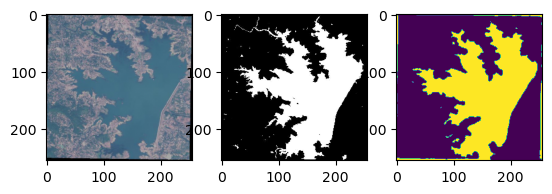

IoU val, 0.8286518255869547
Epochs:43
Train_loss --> Dice: 0.12372197732329368 BCE: 0.16968780579045414 
Valid_loss --> Dice: 0.163924945725335 BCE: 0.23823467559284633
Model Saved


100%|██████████| 80/80 [00:48<00:00,  1.64it/s]


IoU train, 0.8496895469725132


100%|██████████| 9/9 [00:04<00:00,  2.01it/s]


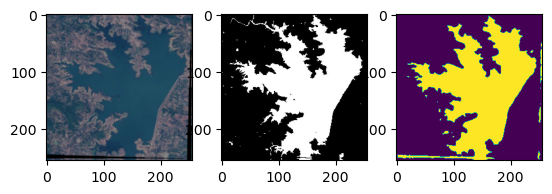

IoU val, 0.825662010245853
Epochs:44
Train_loss --> Dice: 0.12475202307105064 BCE: 0.16783172357827425 
Valid_loss --> Dice: 0.16663126150767008 BCE: 0.2476164549589157


100%|██████████| 80/80 [00:49<00:00,  1.62it/s]


IoU train, 0.8511907264590264


100%|██████████| 9/9 [00:04<00:00,  2.04it/s]


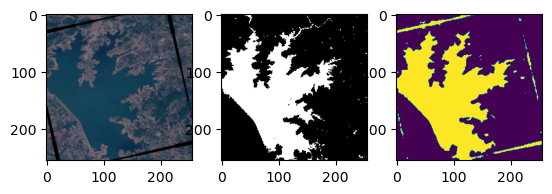

IoU val, 0.8280476464165581
Epochs:45
Train_loss --> Dice: 0.1215461827814579 BCE: 0.1656029767356813 
Valid_loss --> Dice: 0.1627304818895128 BCE: 0.24093415670924717
Model Saved


In [20]:
best_val_dice_loss=np.Inf
best_val_bce_loss=np.Inf

for i in range(EPOCHS):
    train_loss = train_fn(train_loader,model,optimizer)
    valid_loss = eval_fn(valid_loader,model)
    
    train_dice,train_bce=train_loss
    valid_dice,valid_bce=valid_loss
    print(f'Epochs:{i+1}\nTrain_loss --> Dice: {train_dice} BCE: {train_bce} \nValid_loss --> Dice: {valid_dice} BCE: {valid_bce}')
    if valid_dice < best_val_dice_loss or valid_bce < best_val_bce_loss:
        torch.save(model.state_dict(),'best_model_unet_pretrained.pt')
        print('Model Saved')
        best_val_dice_loss=valid_dice
        best_val_bce_loss=valid_bce

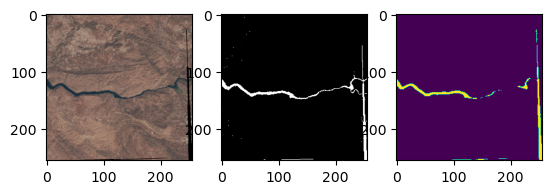

In [47]:
num=11
ratio=0.5

model.load_state_dict(torch.load('./best_model.pt'))

image,mask=next(iter(valid_loader))
image=image[num]
mask=mask[num]
logits_mask=model(image.to('cuda', dtype=torch.float32).unsqueeze(0))
pred_mask=torch.sigmoid(logits_mask)
pred_mask=(pred_mask > ratio)*1.0

f, axarr = plt.subplots(1,3) 
axarr[1].imshow(np.squeeze(mask.numpy()), cmap='gray')
axarr[0].imshow(np.transpose(image.numpy(), (1,2,0)))
axarr[2].imshow(np.transpose(pred_mask.detach().cpu().squeeze(0), (1,2,0)))

In [33]:
import torch
from PIL import Image
from torchvision import transforms, models

# Load the pre-trained model from torchvision
model = models.segmentation.deeplabv3_resnet101(pretrained=True)
model.eval()  # Set the model to evaluation mode

# Define the transform
transform = transforms.Compose([
    transforms.Resize((256, 256)), 
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

# Open your image
image = Image.open('/kaggle/input/satellite-images-of-water-bodies/Water Bodies Dataset/Images/water_body_1.jpg')
# print("Image shape", image.shape)

# # Apply the transform to the image
input_img = transform(image)
input_img = input_img.unsqueeze(0) # add an extra dimension for the batch
# input_img = img
# input_img = input_img.float().unsqueeze(0)  # ensure the input is FloatTensor

# Check if a GPU is available and if not, run the model on a CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_img = input_img.to(device)
model = model.to(device)

# Get the model's prediction
with torch.no_grad():
    output = model(input_img)['out'][0]  # we are interested in the output tensor
    output_predictions = output.argmax(0)  # get the pixel-wise prediction

# The `output_predictions` now contains the segmentation map for the input image


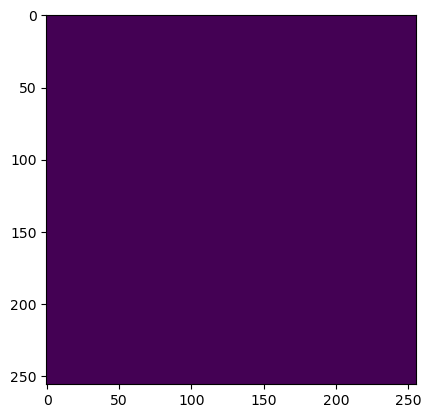

In [32]:
import matplotlib.pyplot as plt

# Convert the tensor to a numpy array
output_predictions123 = output_predictions.cpu().numpy()
# inp = input_img.cpu().numpy()

# Use matplotlib to display the segmentation map
plt.imshow(output_predictions123)
plt.show()

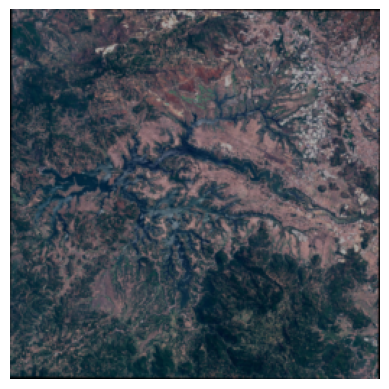

In [29]:
# Convert the input_img tensor to a numpy array for display
input_img_np = input_img.squeeze().cpu().numpy()
input_img_np = input_img_np.transpose((1, 2, 0))  # transpose dimensions
input_img_np = (input_img_np * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]).clip(0, 1)  # denormalize

# Display the input image
plt.imshow(input_img_np)
plt.axis('off')
plt.show()

In [45]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import models
from torchvision.models.segmentation.deeplabv3 import DeepLabHead

def createDeepLabv3(output_channels=1):
    model = models.segmentation.deeplabv3_resnet101(
        pretrained=True, progress=True
    )
    model.classifier = DeepLabHead(2048, output_channels)
    return model

model=createDeepLabv3()
model.to(DEVICE)

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [47]:
print(model.summary)

AttributeError: 'DeepLabV3' object has no attribute 'summary'

In [48]:
def train_fn(data_loader,model,optimizer):
    model.train()
    total_diceloss=0.0
    total_bceloss=0.0
    total_loss = 0.0
    for images ,masks in tqdm(data_loader):
        images=images.to(DEVICE, dtype=torch.float32)
        masks=masks.to(DEVICE, dtype=torch.float32)

        optimizer.zero_grad()

        logits,diceloss,bceloss=model(images,masks)
        diceloss.backward(retain_graph=True)
        bceloss.backward()
        
        optimizer.step()
        total_diceloss+=diceloss.item()
        total_bceloss+=bceloss.item()
        

    return total_diceloss/len(data_loader),total_bceloss/len(data_loader)

def eval_fn(data_loader,model):
    model.eval()
    total_diceloss=0.0
    total_bceloss=0.0
    with torch.no_grad():
        for images ,masks in tqdm(data_loader):
            images=images.to(DEVICE, dtype=torch.float32)
            masks=masks.to(DEVICE, dtype=torch.float32)

            logits,diceloss,bceloss=model(images,masks)
            total_diceloss+=diceloss.item()
            total_bceloss+=bceloss.item()
            
        #Visualization
        for i in range(1):
            image,mask=next(iter(valid_loader))
            image=image[sample_num]
            mask=mask[sample_num]
            logits_mask=model(image.to('cuda', dtype=torch.float32).unsqueeze(0))
            pred_mask=torch.sigmoid(logits_mask)
            pred_mask=(pred_mask > ratio)*1.0
            f, axarr = plt.subplots(1,3) 
            axarr[1].imshow(np.squeeze(mask.numpy()), cmap='gray')
            axarr[0].imshow(np.transpose(image.numpy(), (1,2,0)))
            axarr[2].imshow(np.transpose(pred_mask.detach().cpu().squeeze(0), (1,2,0)))
            plt.show()
            
    return total_diceloss/len(data_loader),total_bceloss/len(data_loader)

optimizer=torch.optim.SGD(model.parameters(), lr=LR, momentum=0.9)
print("device", DEVICE)
#torch.optim.Adam(model.parameters(),lr=LR)

best_val_dice_loss=np.Inf
best_val_bce_loss=np.Inf
EPOCHS = 10
for i in range(EPOCHS):
    train_loss = train_fn(train_loader,model,optimizer)
    valid_loss = eval_fn(valid_loader,model)
    
    train_dice,train_bce=train_loss
    valid_dice,valid_bce=valid_loss
    print(f'Epochs:{i+1}\nTrain_loss --> Dice: {train_dice} BCE: {train_bce} \nValid_loss --> Dice: {valid_dice} BCE: {valid_bce}')
    if valid_dice < best_val_dice_loss or valid_bce < best_val_bce_loss:
        torch.save(model.state_dict(),'best_model_deeplabv3.pt')
        print('Model Saved')
        best_val_dice_loss=valid_dice
        best_val_bce_loss=valid_bce

device cuda


  0%|          | 0/80 [00:02<?, ?it/s]


TypeError: _SimpleSegmentationModel.forward() takes 2 positional arguments but 3 were given